In [1]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt
%cd -

fatal: destination path 'yolov5' already exists and is not an empty directory.
/home/cll/dev/examples/yolov5/yolov5
Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: thop
    Found existing installation: thop 0.1.0.post2206102148
    Uninstalling thop-0.1.0.post2206102148:
      Successfully uninstalled thop-0.1.0.post2206102148
Note: you may need to restart the kernel to use updated packages.
/home/cll/dev/examples/yolov5


In [2]:
%pip install tqdm datasets wandb joblib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Using custom data configuration default
Reusing dataset wider_face (/home/cll/.cache/huggingface/datasets/wider_face/default/1.0.0/b87ac8d8d65665ec6e3c2a5c6ec08d6fddb1b0f2d7f2dc3b5dcecdaf12adf22f)
Using custom data configuration default
Reusing dataset wider_face (/home/cll/.cache/huggingface/datasets/wider_face/default/1.0.0/b87ac8d8d65665ec6e3c2a5c6ec08d6fddb1b0f2d7f2dc3b5dcecdaf12adf22f)
Using custom data configuration default
Reusing dataset wider_face (/home/cll/.cache/huggingface/datasets/wider_face/default/1.0.0/b87ac8d8d65665ec6e3c2a5c6ec08d6fddb1b0f2d7f2dc3b5dcecdaf12adf22f)


Num images in wider_face training set: 12880
Num images in wider_face val set: 3226
Num images in wider_face test set: 16097


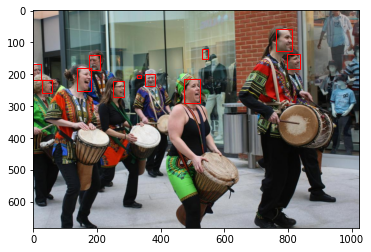

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16097/16097 [01:28<00:00, 181.37it/s]


'yolov5/weights/yolov5l.pt'

In [3]:
import sys
from pathlib import Path
  
from prepare_dataset import (
    convert_to_yolov5_format, 
    create_yolov5_dataset_yaml, 
    download_dataset
)
from yolov5.utils.downloads import attempt_download


(wider_face_train, wider_face_val, wider_face_test) = download_dataset(show_example=True)

convert_to_yolov5_format(wider_face_train, dst_dir=Path("./yolov5/data/train"))
convert_to_yolov5_format(wider_face_val, dst_dir=Path("./yolov5/data/val"))
convert_to_yolov5_format(wider_face_test, dst_dir=Path("./yolov5/data/test"))

sys.path.append('yolov5')
attempt_download('yolov5/weights/yolov5s.pt')
attempt_download('yolov5/weights/yolov5m.pt')
attempt_download('yolov5/weights/yolov5l.pt')

In [4]:
%cd yolov5

/home/cll/dev/examples/yolov5/yolov5


In [6]:
!python -m torch.distributed.launch --nproc_per_node 2 train.py --data data/wider_face.yaml --batch-size 64 --epochs 10 --img-size 768 --project runs/train --name wider_face --weights weights/yolov5s.pt --device 0

/home/cll/.local/lib/python3.10/site-packages/torch/distributed/launch.py:178: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
wandb: Currently logged in as: cll_lambda. Use `wandb login --relogin` to force relogin
train: weights=weights/yolov5s.pt, cfg=, data=data/wider_face.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=768, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=wider_face, exist_ok=False, quad=False

In [ ]:
!python -m torch.distributed.launch --nproc_per_node 2 train.py --data data/wider_face.yaml --batch-size 64 --epochs 10 --img-size 768 --project runs/train --name wider_face --weights weights/yolov5m.pt --device 0

In [ ]:
!python -m torch.distributed.launch --nproc_per_node 2 train.py --data data/wider_face.yaml --batch-size 64 --epochs 10 --img-size 768 --project runs/train --name wider_face --weights weights/yolov5l.pt --device 0